# Quantile Linear Regression

Quantile regression models the conditional quantiles of a target variable instead of just the mean (least square method), making it useful for capturing uncertainty in predictions.  

**Key Ideas**  
- Focuses on ranking observations correctly rather than minimizing error.
- Uses a quantile loss function to estimate specific quantiles of the target distribution.  
- Setting ( $\alpha = 0.5$ ) makes the model predict the conditional median of the response variable.  
- Enables the creation of prediction intervals by estimating lower and upper quantiles.  
- Provides a "trust region" where the true value is likely to fall, depending on chosen quantiles.  
- River package: specialize in online training for data stream.

**Model documentation**: https://riverml.xyz/latest/examples/quantile-regression-uncertainty/

**Requirements:**

!pip install river

# Probabilistic Forecasting

Probabilistic forecasting provides **a distribution of possible future values** rather than a single point estimate, allowing for uncertainty quantification. Instead of predicting only the most likely outcome, it estimates a range of potential outcomes along with their probabilities by outputting a **probability distribution**.

A probabilistic forecast models the conditional probability distribution of a future value $(Y_t)$ given past observations $(\mathcal{H}_{t-1})$. This can be expressed as:  

$$P(Y_t \mid \mathcal{H}_{t-1})$$

where $(\mathcal{H}_{t-1})$ represents the historical data up to time $(t-1)$. Instead of a single prediction $(\hat{Y}_t)$, the model estimates a full probability distribution $(f(Y_t \mid \mathcal{H}_{t-1}))$, which can take different parametric forms, such as a Gaussian:

$$Y_t \mid \mathcal{H}_{t-1} \sim \mathcal{N}(\mu_t, \sigma_t^2)$$

where $(\mu_t)$ is the predicted mean and $(\sigma_t^2)$ represents the uncertainty in the forecast.

Probabilistic forecasting can be handled through various approaches, including **variance forecasters**, **quantile forecasters**, **interval forecasters** or **distribution forecasters**, each capturing uncertainty differently.

In this notebook, we try to forecast the target location by a gaussian density function (or a mixture), the model output follows the form:

```python
{"density": {
                "name": "normal",
                "params": {"loc": y_mean, "scale": y_var}
            }
}
```
![proba_forecast_v2](https://github.com/Tarandro/image_broad/blob/main/proba_forecast_v2.png?raw=true)

In [1]:
import os
import pandas as pd
import numpy as np
import math
from pathlib import Path
import matplotlib.pyplot as plt

TEST_DATA_START_TIME = 90000

current_dir = Path.cwd()
PATH_DATA = current_dir.parent.parent.parent / 'data' / 'bird_feed_data.csv'

def local_test_data_generator(path_data=PATH_DATA, chunksize=1000, start_time=TEST_DATA_START_TIME):
    """
    Generate the local test data yielding one record (dict) at a time.

    :param path_data: path to .csv data file
    :param chunksize: Number of rows to read at a time (default is 1000).
    """
    prev_time = start_time
    for chunk in pd.read_csv(path_data, chunksize=chunksize):
        for k, row in chunk.iterrows():
            if k > 500:
                row['time'] = row['time'] / math.pi  # don't ask
                if row['time'] > prev_time:
                    prev_time = row['time']
                    yield row.to_dict()


def remote_test_data_generator(chunksize=1000, start_time=TEST_DATA_START_TIME):
    """
    Generate the remote test data yielding one record (dict) at a time.

    :param chunksize: Number of rows to read at a time (default is 1000).
    """
    url = 'https://raw.githubusercontent.com/microprediction/birdgame/refs/heads/main/data/bird_feed_data.csv'
    prev_time = start_time
    for chunk in pd.read_csv(url, chunksize=chunksize):
        for k, row in chunk.iterrows():
            if k > 500:
                row['time'] = row['time'] / math.pi  # don't ask
                if row['time'] > prev_time:
                    prev_time = row['time']
                    yield row.to_dict()

### Warm up example

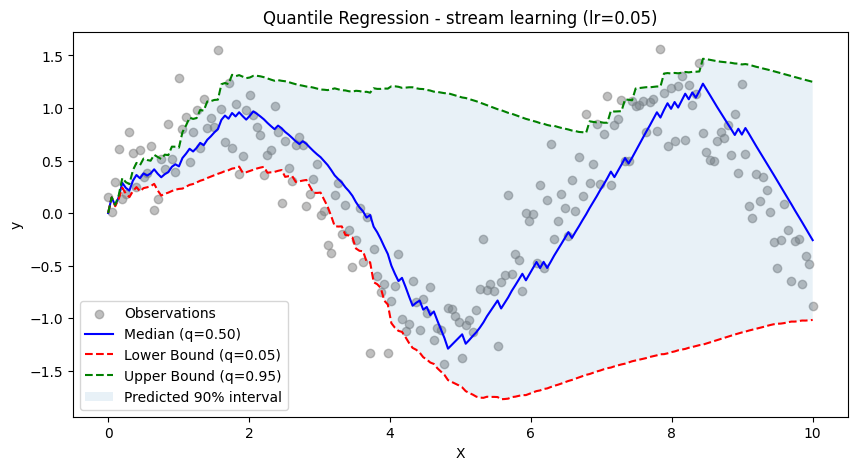

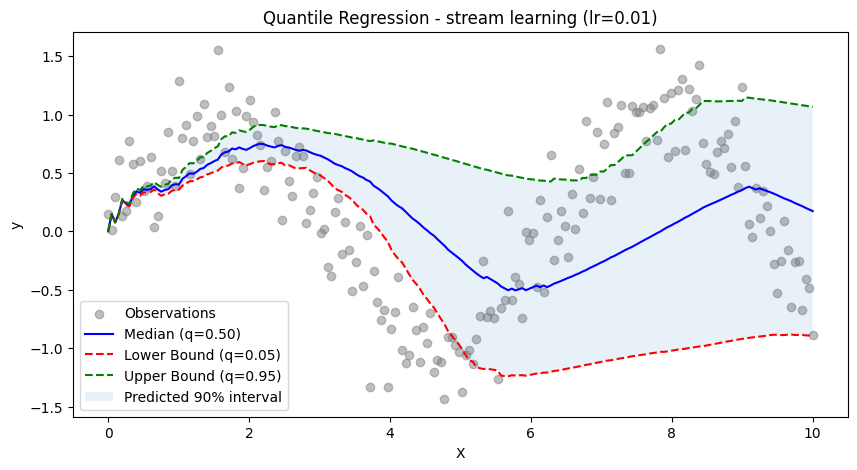

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from river import linear_model, preprocessing, optim

def visualize_quantile_regression(lr=0.05):
    """ Function to visualize quantile regression with different quantiles. """

    # Generate synthetic data
    np.random.seed(42)
    X = np.linspace(0, 10, 200)
    y = np.sin(X) + np.random.normal(0, 0.3, size=X.shape)  # True function + noise

    # Initialize models for different quantiles
    models = {}
    quantiles = [0.05, 0.5, 0.95]

    for alpha in quantiles:
        scale = preprocessing.StandardScaler()
        learn = linear_model.LinearRegression(
            intercept_lr=0,
            optimizer=optim.SGD(lr),
            loss=optim.losses.Quantile(alpha=alpha)
        )
        models[f"q {alpha:.2f}"] = preprocessing.TargetStandardScaler(regressor=scale | learn)

    # Make predictions and Train Quantile Regression models
    predictions = {q: [] for q in models.keys()}
    for x_val, y_val in zip(X, y):
        x_dict = {"feature": x_val}
        for q in models.keys():
            pred = models[q].predict_one(x_dict)
            predictions[q].append(pred)
            models[q].learn_one(x_dict, y_val)

    plt.figure(figsize=(10, 5))
    plt.scatter(X, y, label="Observations", alpha=0.5, color="gray")
    plt.plot(X, predictions["q 0.50"], label="Median (q=0.50)", color="blue")
    plt.plot(X, predictions["q 0.05"], label="Lower Bound (q=0.05)", color="red", linestyle="--")
    plt.plot(X, predictions["q 0.95"], label="Upper Bound (q=0.95)", color="green", linestyle="--")
    plt.fill_between(X, predictions["q 0.05"], predictions["q 0.95"], alpha=0.1, label="Predicted 90% interval")

    plt.xlabel("X")
    plt.ylabel("y")
    plt.legend()
    plt.title(f"Quantile Regression - stream learning (lr={lr})")
    plt.show()

# Run quantile regression for different learning rates
for lr in [0.05, 0.01]:
    visualize_quantile_regression(lr=lr)


In [3]:
from birdgame.trackers.trackerbase import TrackerBase
import math
import numpy as np
from river import linear_model, optim
from river import preprocessing
    

class QuantileRegressionRiverTracker(TrackerBase):
    """
    A model that tracks the dove location using Quantile regression on stream learning.

    Parameters
    ----------
    horizon : int
        The "look-ahead" in time after which the recorded data becomes valid for updating.
    """

    def __init__(self, horizon=10):
        super().__init__(horizon)
        self.current_x = None
        self.miss_count = 0

        # Initialize river models dictionary
        self.models = {}
        self.lr = 0.005
        for i, alpha in enumerate([0.05, 0.5, 0.95]):
            scale = preprocessing.StandardScaler()

            # you can optimize learning rate or use other optimizer (RMSProp, ...)
            learn = linear_model.LinearRegression(
                intercept_lr=0,
                optimizer=optim.SGD(self.lr),
                loss=optim.losses.Quantile(alpha=alpha)
            )

            model = scale | learn

            self.models[f"q {alpha:.2f}"] = preprocessing.TargetStandardScaler(regressor=model)

    def tick(self, payload):
        """
        Ingest a new record (payload), store it internally and update the
        estimated Gaussian mixture model.

        The core distribution captures regular variance, while the tail distribution
        captures extreme deviations.

        Parameters
        ----------
        payload : dict
            Must contain 'time' (int/float) and 'dove_location' (float).
        """

        x = payload['dove_location']
        t = payload['time']
        self.add_to_quarantine(t, x)
        self.current_x = x
        prev_x = self.pop_from_quarantine(t)

        if prev_x is not None:

            ### (optional idea)
            # Get the predicted quantile values from the models
            if "q 0.05" in self.models:
                y_lower = self.models["q 0.05"].predict_one({"x": prev_x})
                y_upper = self.models["q 0.95"].predict_one({"x": prev_x})

                # Check if observed value `x` is between the predicted quantiles
                if y_lower <= x <= y_upper:
                    prediction_error = 0  # prediction is within bounds
                    # idea: learn two time when prediction is within bounds
                    for i, alpha in enumerate([0.05, 0.5, 0.95]):
                        self.models[f"q {alpha:.2f}"].learn_one({"x": prev_x}, x)
                else:
                    prediction_error = 1  # prediction is outside bounds
            ###

            # River learn_one (online learning)
            for i, alpha in enumerate([0.05, 0.5, 0.95]):
                self.models[f"q {alpha:.2f}"].learn_one({"x": prev_x}, x)

            self.count += 1

    def predict(self):
        """
        Return a dictionary representing the best guess of the distribution
        modeled as a Gaussian distribution.
        """
        x_mean = self.current_x
        components = []

        if "q 0.05" in self.models:
            # Quantile regression prediction 5%, 50% and 95%
            y_lower = self.models["q 0.05"].predict_one({"x": self.current_x})
            y_mean = self.models["q 0.50"].predict_one({"x": self.current_x})
            y_upper = self.models["q 0.95"].predict_one({"x": self.current_x})

            loc = y_mean
            scale = np.abs((y_upper - y_lower)) / 3.289707253902945    # 3.289707253902945 = (norm.ppf(0.95) - norm.ppf(0.05))
            scale = max(scale, 1e-6)
        else:
            loc = x_mean
            scale = 1.0

        components = {
            "density": {
                "type": "builtin",
                "name": "norm",
                "params": {"loc": loc, "scale": scale}
            },
            "weight": 1
        }

        prediction_density = {
            "type": "mixture",
            "components": [components]
        }
        return prediction_density

In [4]:
import typing


def train():
    pass


def infer(
    payload_stream: typing.Iterator[dict],
):
    # Parameters
    HORIZON = 10

    # Initialize Model
    model = QuantileRegressionRiverTracker(horizon=HORIZON)

    yield  # Signal initialization completion

    for payload in payload_stream:
        model.tick(payload)
        yield model.predict()

In [5]:
def compute_pdf_score(past_pdf, observed_dove_location):
    """ Compute weighted PDF score of a normal distribution """
    weighted_pdf_score = 0
    highest_weight = 0
    stored_predictions = []

    for component in past_pdf.get('components', []):
        density = component['density']
        loc, scale, weight = density['params']['loc'], density['params']['scale'], component['weight']

        # Compute PDF score (Gaussian)
        pdf_score = (1 / (math.sqrt(2 * math.pi * scale**2))) * \
                    math.exp(-((observed_dove_location - loc) ** 2) / (2 * scale**2))

        weighted_pdf_score += weight * pdf_score

        # Store prediction with highest weight
        if weight > highest_weight:
            stored_predictions = [(loc, scale, observed_dove_location, pdf_score)]
            highest_weight = weight

    return round(weighted_pdf_score, 3), stored_predictions


def find_past_pdf(pdf_history, current_time, horizon):
    """ Function to find the most recent valid past prediction """
    for past_time, p_pdf in reversed(pdf_history):
        if past_time < current_time - horizon:
            return p_pdf
    return None  # No valid past prediction

In [6]:
import time
import json
from tqdm.auto import tqdm

# Parameters
HORIZON = 10
MAX_TRACKER_COUNT = 10000
SHOW_PRINT = True
STEP_PRINT = 1000

# Initialize Tracker
tracker = QuantileRegressionRiverTracker(horizon=HORIZON)

# History to track evaluation metrics and the PDFs
pdf_score_history = []
pdf_history = []
store_pred = []

# Start Processing Data
start_time = time.time()
if os.path.exists(PATH_DATA):
    data_generator = local_test_data_generator()
else:
    data_generator = remote_test_data_generator()

for payload in tqdm(data_generator, position=0, leave=True):
    try:
        tracker.tick(payload)
        pdf = tracker.predict()
        current_time = payload['time']

        # Store the latest PDF prediction
        pdf_history.append((current_time, pdf))

        # Find past PDF predicition for evaluation
        past_pdf = find_past_pdf(pdf_history, current_time, HORIZON)

        if past_pdf:
            observed_dove_location = payload['dove_location']
            weighted_pdf_score, predictions = compute_pdf_score(past_pdf, observed_dove_location)

            # Store results
            pdf_score_history.append(weighted_pdf_score)
            store_pred.extend([(current_time, *p) for p in predictions])

            if SHOW_PRINT and len(pdf_history) % STEP_PRINT == 0:
                print(
                    f"[{tracker.count}] PDF Score: {weighted_pdf_score:.4f} / true: {observed_dove_location:.4f} / "
                    f"pred: {predictions[0][0]:.4f} / dif: {observed_dove_location - predictions[0][0]:.4f} / "
                    f"scale: {predictions[0][1]:.4f}"
                )
        else:
            if SHOW_PRINT:
                print(f"[{tracker.count}] No valid past PDF for evaluation.")

    except json.JSONDecodeError:
        print(f"[{tracker.count}] Error: Could not parse JSON payload.")

    if tracker.count > MAX_TRACKER_COUNT:
        break

end_time = time.time()
print(f"Execution Time: {end_time - start_time:.2f} seconds")

0it [00:00, ?it/s]

[0] No valid past PDF for evaluation.
[0] No valid past PDF for evaluation.
[368] PDF Score: 12.9370 / true: 8396.0902 / pred: 8396.1063 / dif: -0.0160 / scale: 0.0252
[726] PDF Score: 36.4800 / true: 8395.4667 / pred: 8395.4720 / dif: -0.0053 / scale: 0.0093
[1061] PDF Score: 0.0000 / true: 8395.8812 / pred: 8395.8778 / dif: 0.0034 / scale: 0.0003
[1449] PDF Score: 9.0240 / true: 8395.0469 / pred: 8395.0572 / dif: -0.0103 / scale: 0.0049
[1819] PDF Score: 62.0400 / true: 8395.6477 / pred: 8395.6447 / dif: 0.0031 / scale: 0.0020
[2213] PDF Score: 0.0000 / true: 8395.7813 / pred: 8395.7468 / dif: 0.0344 / scale: 0.0031
[2553] PDF Score: 735.4930 / true: 8395.7586 / pred: 8395.7583 / dif: 0.0003 / scale: 0.0003
[2929] PDF Score: 20.4520 / true: 8395.0275 / pred: 8395.0273 / dif: 0.0002 / scale: 0.0195
[3319] PDF Score: 0.0000 / true: 8394.8244 / pred: 8394.9851 / dif: -0.1607 / scale: 0.0270
[3640] PDF Score: 15.7880 / true: 8395.1889 / pred: 8395.1991 / dif: -0.0102 / scale: 0.0061
[401

In [7]:
def compute_metric_stats(df):
    """Compute and print median, mean and std of metrics"""
    stats = df.agg(["median", "mean", "std"]).round(3)
    
    for stat_name, values in stats.iterrows():
        print(f"{stat_name.capitalize()}: {values.to_dict()}")

    return stats

skip_length = 500
# Create history score (skipping first 500 values -> skip warmup of model)
scores = pd.DataFrame({"pdf_score": pdf_score_history[skip_length:]})
stats_summary = compute_metric_stats(scores)

pred_summary = pd.DataFrame(store_pred[skip_length:], columns=["time", "loc", "scale", "dove_location", "pdf_score"])
pred_summary.round(4)

Median: {'pdf_score': 17.813}
Mean: {'pdf_score': 30.227}
Std: {'pdf_score': 62.476}


,time,loc,scale,dove_location,pdf_score
0,102671.0,8396.4442,0.0682,8396.5300,2.6535
1,102672.0,8396.4490,0.0699,8396.5121,3.7952
2,102674.0,8396.4490,0.0699,8396.5121,3.7952
3,102685.0,8396.4365,0.0644,8396.5139,3.0061
4,102686.0,8396.4365,0.0644,8396.5285,2.2338
...,...,...,...,...,...
26184,365278.0,8397.5869,0.0075,8397.5885,52.2310
26185,365279.0,8397.5869,0.0075,8397.5813,40.5963
26186,365285.0,8397.6006,0.0068,8397.5813,1.0406
26187,365288.0,8397.6026,0.0068,8397.5819,0.5537


In [8]:
def plot_dove_predictions(store_pred, start_ind=1000, window_size=200, max_pdf_score=100):
    """
    Plots observed vs. predicted dove locations with uncertainty and PDF scores.

    Parameters:
        store_pred (list of tuples): Stored predictions in the format (time, loc, scale, dove_location, pdf_score).
        start_ind (int): Starting index for slicing data.
        window_size (int): Number of points to plot.
        max_pdf_score (float): Maximum value for clipping PDF scores (to prevent extreme values from dominating).
    """
    end_ind = start_ind + window_size
    
    # time, dove_location, predictions and metrics
    data_slice = np.array(store_pred[start_ind:end_ind], dtype=np.float64)
    times, predicted_locs, scales, dove_location, pdf_scores = data_slice.T

    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Plot locations (left y-axis)
    ax1.scatter(times, dove_location, color="grey", label="Observed Dove Location", marker="o", alpha=0.9)
    ax1.plot(times, predicted_locs, label="Predicted Mean (loc)", color="red", linestyle="-")
    ax1.fill_between(times, predicted_locs - scales, predicted_locs + scales, color="red", alpha=0.2, label="±1 Std Dev (Scale)")

    # Left y-axis labels
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Dove Location")
    ax1.legend(loc="upper left")
    ax1.grid(True)

    # Create second right y-axis for metric scores
    ax2 = ax1.twinx()
    ax2.scatter(times, np.clip(pdf_scores, 0, max_pdf_score), label="PDF Scores", color="green", marker="|", alpha=0.2)

    # Right y-axis labels
    ax2.set_ylabel("PDF Score")
    ax2.legend(loc="upper right")

    plt.title("Observed vs. Predicted Dove Location with Uncertainty and PDF Scores")
    plt.show()


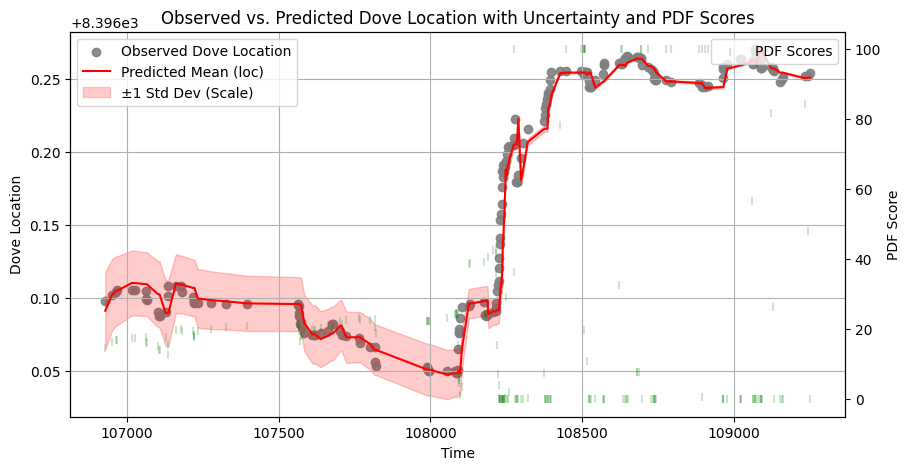

In [9]:
start_ind=1000
window_size=200
plot_dove_predictions(store_pred, start_ind=start_ind, window_size=window_size)

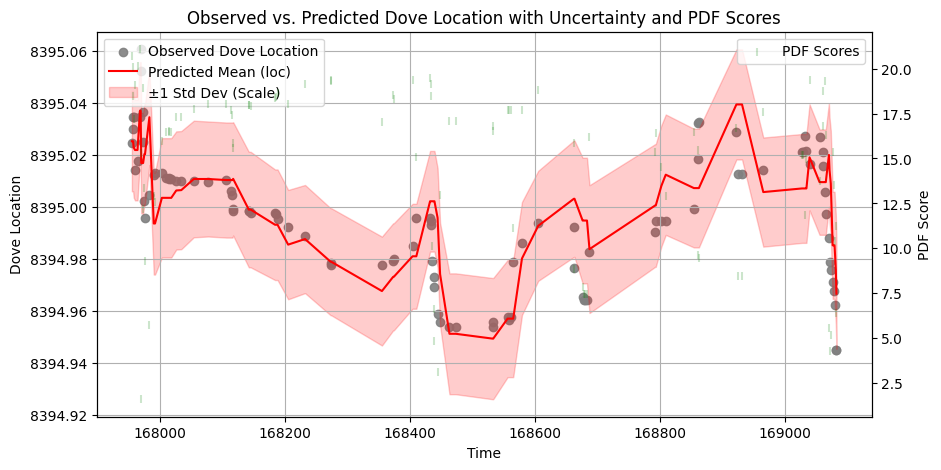

In [10]:
start_ind=8000
window_size=100
plot_dove_predictions(store_pred, start_ind=start_ind, window_size=window_size)